Cross-Validation Mean Absolute Error: 4.41 (±0.21)


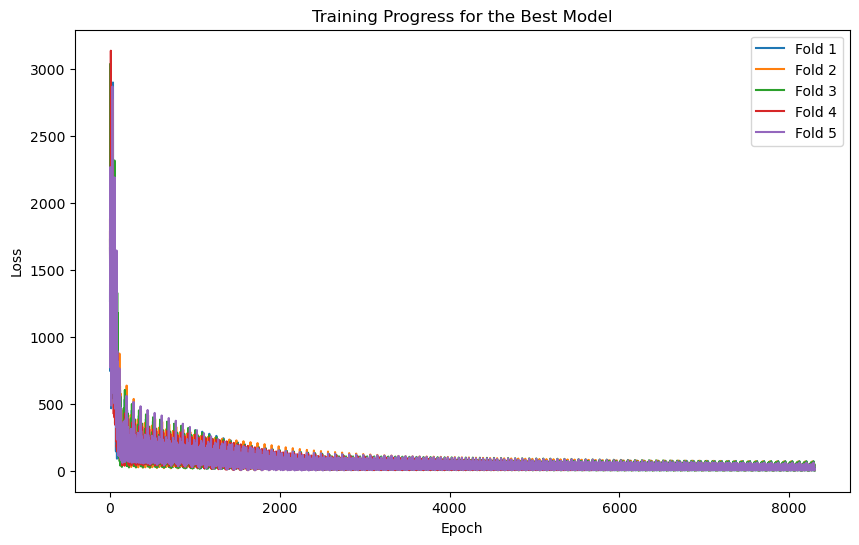

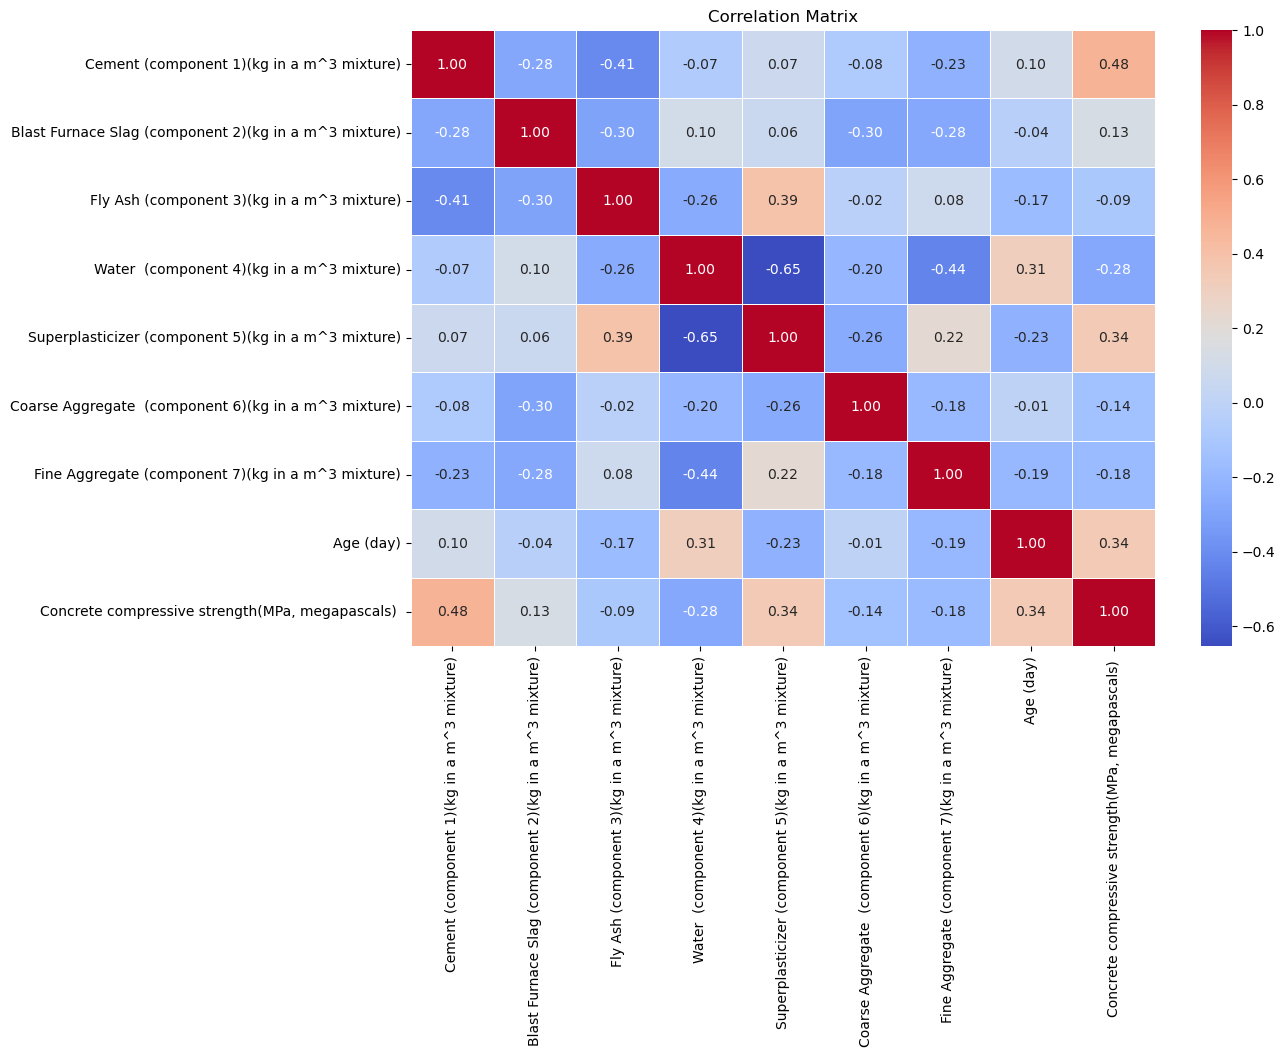

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_val_data = pd.read_csv('train-val.csv')
test_data = pd.read_csv('test.csv')

# Split the data into independent variables and target variable
X_train_val = train_val_data.drop('Concrete compressive strength(MPa, megapascals) ', axis=1)
y_train_val = train_val_data['Concrete compressive strength(MPa, megapascals) ']
X_test = test_data.drop('Concrete compressive strength(MPa, megapascals) ', axis=1)
y_test = test_data['Concrete compressive strength(MPa, megapascals) ']

# Scaling the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_val_tensor = torch.Tensor(X_train_val_scaled).to(device)
y_train_val_tensor = torch.Tensor(y_train_val.values).view(-1, 1).to(device)
X_test_tensor = torch.Tensor(X_test_scaled).to(device)
y_test_tensor = torch.Tensor(y_test.values).view(-1, 1).to(device)

# Defining the neural network architecture
class ConcreteStrengthModel(nn.Module):
    def __init__(self, input_size):
        super(ConcreteStrengthModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

model = ConcreteStrengthModel(X_train_val_tensor.shape[1]).to(device)

# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, k, num_epochs, batch_size, learning_rate):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mae_scores = []
    final_models = []
    training_losses = []
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val_tensor)):
        X_train, X_val = X_train_val_tensor[train_index], X_train_val_tensor[val_index]
        y_train, y_val = y_train_val_tensor[train_index], y_train_val_tensor[val_index]

        model = ConcreteStrengthModel(X_train.shape[1]).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        fold_training_losses = []

        for epoch in range(num_epochs):
            for i in range(0, X_train.size(0), batch_size):
                inputs = X_train[i:i + batch_size]
                labels = y_train[i:i + batch_size]
                model.train()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                fold_training_losses.append(loss.item())

    # Storing training losses for plotting later
        training_losses.append(fold_training_losses)

    # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            mae = mean_absolute_error(y_val, val_outputs.cpu().numpy())
            mae_scores.append(mae)

    # Save the model for this fold
        final_models.append(model)

    return mae_scores, final_models, training_losses

# Hyperparameters
k = 5  # Number of folds for cross-validation
num_epochs = 100
batch_size = 8
learning_rate = 0.001

# Performing the k-fold cross-validation
[mae_scores, models, t_losses] = k_fold_cross_validation(X_train_val_tensor, y_train_val_tensor, k, num_epochs, batch_size, learning_rate)

# Calculate the train-val mean MAE and standard deviation
mean_mae = sum(mae_scores) / len(mae_scores)
std_mae = sum((x - mean_mae) ** 2 for x in mae_scores) / (len(mae_scores) - 1)

print(f'Cross-Validation Mean Absolute Error: {mean_mae:.2f} (±{std_mae:.2f})')

# Choose the best model based on the lowest mean absolute error
best_model_index = mae_scores.index(min(mae_scores))
best_model = models[best_model_index]

# Plotting the Training Progress for the best model for each fold
plt.figure(figsize=(10, 6))

min_epochs = min(len(losses) for losses in t_losses)

for fold in range(k):
    plt.plot(range(1, min_epochs + 1), t_losses[fold][:min_epochs], label=f'Fold {fold + 1}')

plt.title('Training Progress for the Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Correlation Table
correlation_matrix = train_val_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Test Set Mean Absolute Error: 4.31


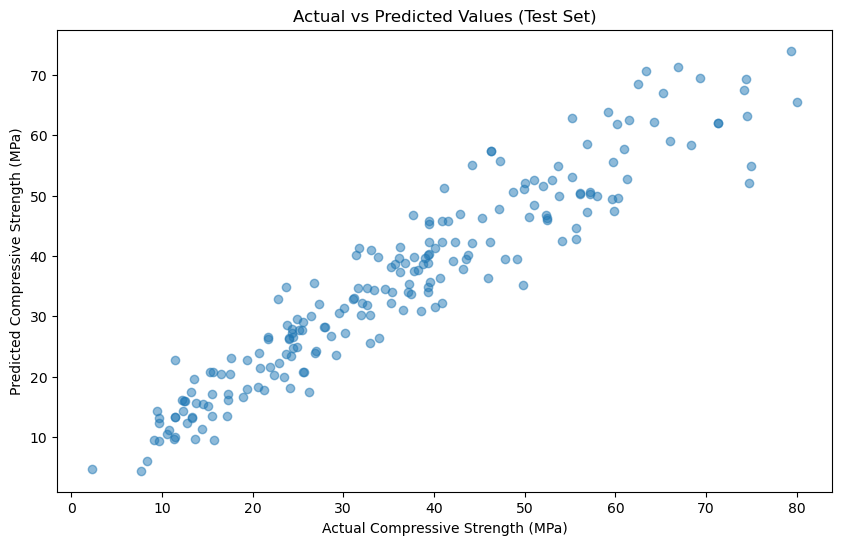

In [7]:
# Evaluate the final model on the test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_mae = mean_absolute_error(y_test, test_outputs.cpu().numpy())

print(f'Test Set Mean Absolute Error: {test_mae:.2f}')

# Actual vs Predicted Values Scatter Plot for Test Set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tensor).cpu().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_outputs, alpha=0.5)
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Actual Compressive Strength (MPa)')
plt.ylabel('Predicted Compressive Strength (MPa)')
plt.show()